In [2]:
from matplotlib import image
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import numpy 

torch.manual_seed(0)

from models_dif import DIFDensityEstimator, LocationScaleFlow, SoftmaxWeight
from models_em import EMDensityEstimator

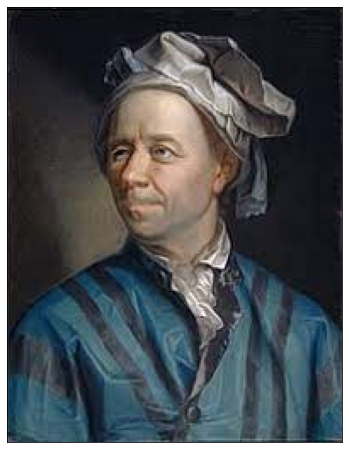

In [3]:
rgb = image.imread("euler.jpg")
figure = plt.figure(figsize = (12,8))
plt.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
plt.imshow(rgb)
lines, columns = rgb.shape[:-1]

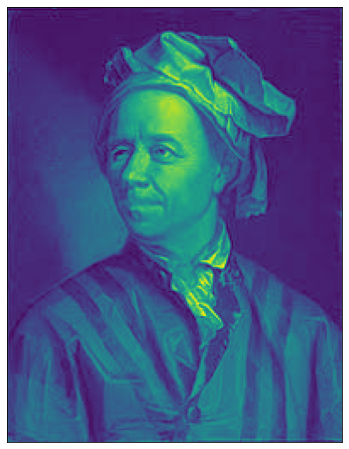

In [4]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
grey = torch.tensor(rgb2gray(rgb))
figure = plt.figure(figsize = (12,8))
plt.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
plt.imshow(grey)
filename_png = 'euler_gray_scale.png'
figure.savefig(filename_png, bbox_inches='tight', pad_inches=0)

In [22]:
#Sample data according to image
vector_density = grey.flatten()
vector_density = vector_density/torch.sum(vector_density)
lines, columns = grey.shape
num_samples = 100000000
cat = torch.distributions.Categorical(probs = vector_density)
categorical_samples = cat.sample([num_samples])
target_samples = torch.cat([((categorical_samples//columns + torch.rand(num_samples))/lines).unsqueeze(-1), ((categorical_samples%columns + torch.rand(num_samples))/columns).unsqueeze(-1)], dim = -1)

<ipython-input-22-d65448e7b119>:8: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  target_samples = torch.cat([((categorical_samples//columns + torch.rand(num_samples))/lines).unsqueeze(-1), ((categorical_samples%columns + torch.rand(num_samples))/columns).unsqueeze(-1)], dim = -1)


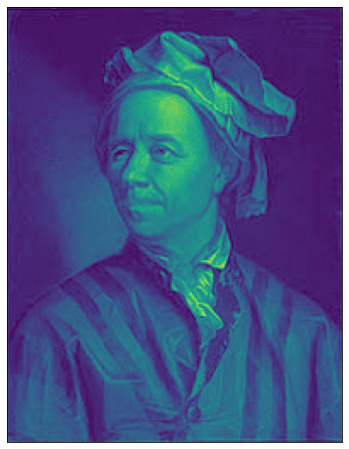

In [23]:
hist_target_samples, x_edges, y_edges = numpy.histogram2d(target_samples[:,1].numpy(), target_samples[:, 0].numpy(), bins = (5*lines, 5*columns),range = [[0, 1],[0,1]], normed = True)
figure = plt.figure(figsize = (12,8))
plt.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
plt.imshow(torch.flip(torch.flip(torch.tensor(hist_target_samples).T,[0,1]),[0,1]),extent = [0,columns,0, lines])
filename_png = 'euler_samples.png'
figure.savefig(filename_png, bbox_inches='tight', pad_inches=0)

In [25]:
pi = torch.tensor(hist_target_samples)
print(torch.mean(torch.nan_to_num(pi*torch.log(pi), nan = 0.0)))

tensor(0.2293, dtype=torch.float64)


In [9]:
#Run EM
linspace_x = 7
linspace_y = 7
K = linspace_x * linspace_y
EM = EMDensityEstimator(target_samples,K)
EM.m = torch.cartesian_prod(torch.linspace(0, 1,linspace_x),torch.linspace(0, 1, linspace_y))
EM.train(500)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [21:25<00:00,  2.57s/it, loss = -0.15892215073108673]


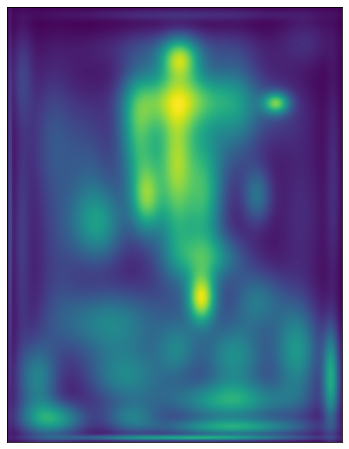

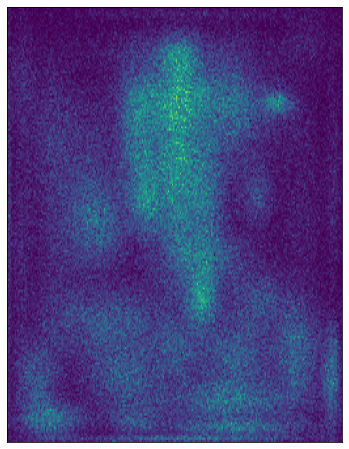

In [10]:
with torch.no_grad():
    grid = torch.cartesian_prod(torch.linspace(0,1,lines),torch.linspace(0,1, columns))
    density = torch.exp(EM.log_density(grid)).reshape(lines,columns).T
    figure = plt.figure(figsize = (12,8))
    plt.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
    plt.imshow(torch.flip(torch.flip(density.T,[0,1]),[0,1]),extent = [0,columns,0, lines])
    dif_samples = EM.sample_model(target_samples.shape[0])
    hist_dif_samples, x_edges, y_edges = numpy.histogram2d(dif_samples[:,1].numpy(), dif_samples[:, 0].numpy(), bins = (lines, columns),range = [[0, 1],[0,1]])
    figure = plt.figure(figsize = (12,8))
    plt.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
    plt.imshow(torch.flip(torch.flip(torch.tensor(hist_dif_samples).T,[0,1]),[0,1]),extent = [0,columns,0, lines])

In [9]:
#Run DIF
initial_T = LocationScaleFlow(K,2)
initial_T.m = nn.Parameter(EM.m)
initial_T.log_s = nn.Parameter(EM.log_s)

initial_w = SoftmaxWeight(K, 2, [128,128,128])
initial_w.f[-1].bias = nn.Parameter(EM.log_pi)
initial_w.f[-1].weight = nn.Parameter(torch.zeros(K,initial_w.network_dimensions[-2]))

dif = DIFDensityEstimator(target_samples,K)
dif.T = initial_T
dif.w = initial_w

epochs = 1000
batch_size = 30000
dif.train(epochs, batch_size)

  0%|                                                                                                                                                            | 0/1000 [01:00<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
#Save dif
filename = 'euler_dif.sav'
torch.save(dif,filename)

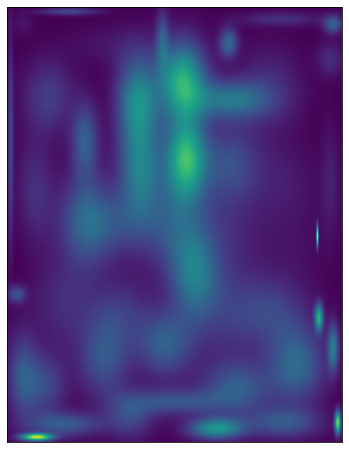

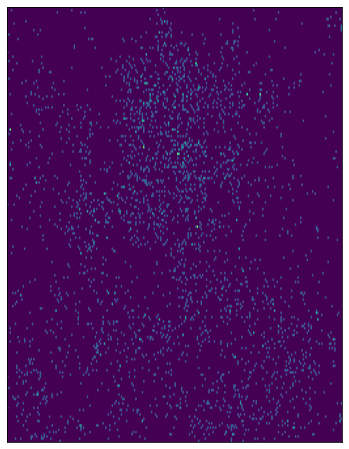

In [15]:
with torch.no_grad():
    grid = torch.cartesian_prod(torch.linspace(0,1,lines),torch.linspace(0,1,columns))
    density = torch.exp(dif.log_density(grid)).reshape(lines,columns).T
    figure = plt.figure(figsize = (12,8))
    plt.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
    plt.imshow(torch.flip(torch.flip(density.T,[0,1]),[0,1]),extent = [0,columns,0, lines])
    dif_samples = dif.sample_model(target_samples.shape[0])
    hist_dif_samples, x_edges, y_edges = numpy.histogram2d(dif_samples[:,1].numpy(), dif_samples[:, 0].numpy(), bins = (lines, columns),range = [[0, 1],[0,1]])
    figure = plt.figure(figsize = (12,8))
    plt.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
    plt.imshow(torch.flip(torch.flip(torch.tensor(hist_dif_samples).T,[0,1]),[0,1]),extent = [0,columns,0, lines])